<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/multidim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Cloning repo


In [2]:
!pip install corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn import clone
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_sparse_spd_matrix

from active_learning_ratio_estimation.model import SinglyParameterizedRatioModel, DenseClassifier, FlipoutClassifier
from active_learning_ratio_estimation.dataset import ParamGrid, SinglyParameterizedRatioDataset

np.random.seed(0)
tf.random.set_seed(0)

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=782f8a5f08831973cae1b89eb3ef7497758e0c241765c38e93f4bdab7b448438
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
# matplotlib setup
%matplotlib inline

size=24
params = {
    'legend.fontsize': size*0.75,
    'figure.figsize': (10, 5),
    'axes.labelsize': size,
    'axes.titlesize': size,
    'xtick.labelsize': size * 0.75,
    'ytick.labelsize': size * 0.75,
    'font.family': 'sans-serif',
    'axes.titlepad': 12.5
}
plt.rcParams.update(params)

In [0]:
class MultiDimToyModel(tfd.TransformedDistribution):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

        # compose linear transform
        R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7).astype(np.float32)
        self.R = R
        transform = tf.linalg.LinearOperatorFullMatrix(R)
        bijector = tfp.bijectors.AffineLinearOperator(scale=transform)

        super().__init__(distribution=self.z_distribution, bijector=bijector)

    @property
    def z_distribution(self):
        z_distribution = tfd.Blockwise([
            tfd.Normal(loc=self.alpha, scale=1),  # z1
            tfd.Normal(loc=self.beta, scale=3),  # z2
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                components_distribution=tfd.Normal(
                    loc=[-2, 2],
                    scale=[1, 0.5]
                )
            ),  # z3
            tfd.Exponential(3),  # z4
            tfd.Exponential(0.5),  # z5
        ])
        return z_distribution

Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.ScaleMatvecLinearOperator(...))`.


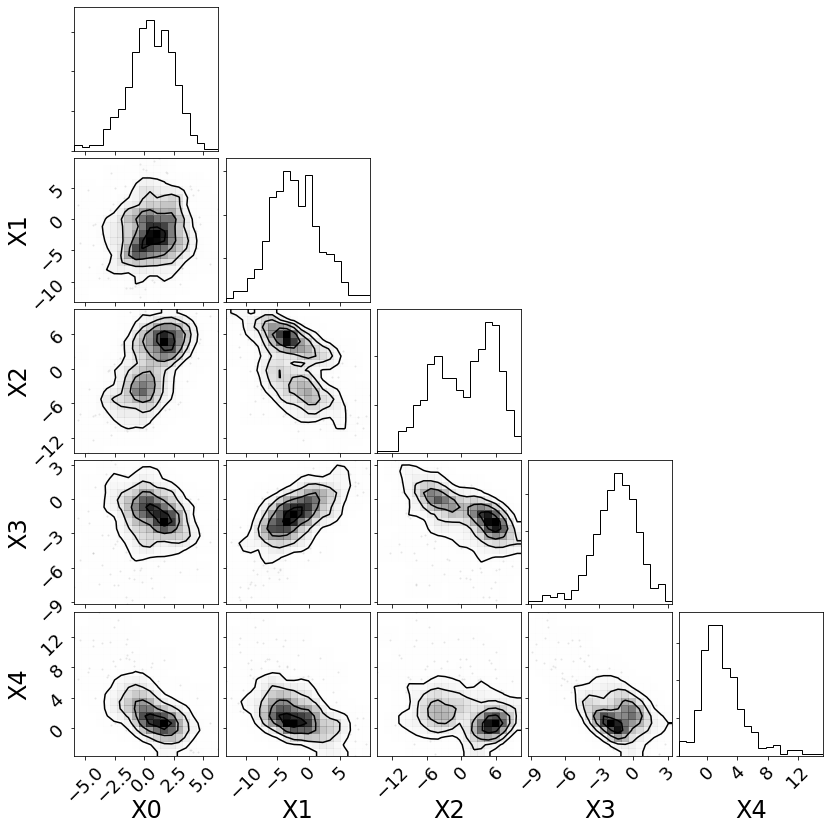

In [5]:
# Plot histograms / correlations of true distributions
true_alpha = 1
true_beta = -1
p_true = MultiDimToyModel(alpha=1, beta=-1)
X_true = p_true.sample(500)
fig = corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

In [6]:
# find exact maximum likelihood
var_alpha = tf.Variable(tf.constant(0, dtype=tf.float32))
var_beta = tf.Variable(tf.constant(0, dtype=tf.float32))
p_var = MultiDimToyModel(var_alpha, var_beta)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
n_iter = int(1e3)
nll = tf.function(lambda: -tf.keras.backend.sum(p_var.log_prob(X_true)))

for i in range(n_iter):
    optimizer.minimize(nll, [var_alpha, var_beta])

alpha_mle = var_alpha.numpy()
beta_mle = var_beta.numpy()
theta_mle = np.array([alpha_mle, beta_mle])
max_log_prob = p_var.log_prob(X_true)

print(f'\nExact MLE: alpha={alpha_mle:.2f}, beta={beta_mle:.2f}')


Exact MLE: alpha=0.99, beta=-1.19


In [0]:
# create dataset for fitting
param_grid_train = ParamGrid(bounds=[(-3, 3), (-3, 3)], num=30)
theta_0 = np.array([alpha_mle, beta_mle])
ds = SinglyParameterizedRatioDataset.from_simulator(
    simulator_func=MultiDimToyModel,
    theta_0=theta_0,
    theta_1_iterator=param_grid_train,
    n_samples_per_theta=500
)

In [8]:
# hyperparams
epochs = 20
patience = 5
validation_split = 0.1
n_hidden = (30, 30)

# regular model
regular_estimator = DenseClassifier(
    n_hidden=n_hidden,
    activation='tanh',
    epochs=epochs,
    patience=patience,
    validation_split=validation_split
)
regular_model = SinglyParameterizedRatioModel(estimator=regular_estimator, calibration_method=None)

# bayesian model
bayesian_estimator = FlipoutClassifier(
    n_hidden=n_hidden,
    activation='relu',
    epochs=epochs,
    patience=patience,
    validation_split=validation_split
)
bayesian_model = SinglyParameterizedRatioModel(estimator=bayesian_estimator, calibration_method=None)

# fit models
regular_model.fit(ds)
bayesian_model.fit(ds)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25313/25313 - 33s - loss: 0.4095 - accuracy: 0.7903 - val_loss: 0.4051 - val_accuracy: 0.7915
Epoch 2/20
25313/25313 - 33s - loss: 0.3987 - accuracy: 0.7968 - val_loss: 0.4018 - val_accuracy: 0.7936
Epoch 3/20
25313/25313 - 34s - loss: 0.3982 - accuracy: 0.7971 - val_loss: 0.4009 - val_accuracy: 0.7947
Epoch 4/20
25313/25313 - 34s - loss: 0.3981 - accuracy: 0.7970 - val_loss: 0.4001 - val_accuracy: 0.7938
Epoch 5/20
25313/25313 - 34s - loss: 0.3978 - accuracy: 0.7975 - val_loss: 0.3997 - val_

In [9]:
# predict log-likelihood contours
num_plot = 15
alpha_bounds = (0.75, 1.25) 
beta_bounds = (-2, 0)
plot_grid = ParamGrid(bounds=[alpha_bounds, beta_bounds], num=num_plot)
Alphas, Betas = plot_grid.meshgrid()

contours = dict()
mles = dict()

for model_name, model in [('Regular', regular_model), ('Bayesian', bayesian_model)]:

    print(f'Uncalibrated parameter scan with {model_name} model')
    contour, mle = model.nllr_param_scan(
        x=X_true,
        param_grid=plot_grid,
        notebook=True
    )

    contours[model_name] = contour
    mles[model_name] = mle.tolist()

    if model_name == 'Bayesian':
        continue
    
    print(f'Calibrated parameter scan with {model_name} model')
    cal_contour, cal_mle = model.nllr_param_scan_with_calibration(
        x=X_true,
        param_grid=plot_grid,
        n_samples_per_theta=int(2e5),
        simulator_func=MultiDimToyModel,
        notebook=True
    )

    contours[f'{model_name} Calibrated'] = cal_contour 
    mles[f'{model_name} Calibrated'] = cal_mle.tolist()

Uncalibrated parameter scan with Regular model



Calibrated parameter scan with Regular model



Uncalibrated parameter scan with Bayesian model


In [10]:
# Calculate contours of exact negative log likelihood ratio
@tf.function
def nllr_exact(alpha, beta, X):
    p_theta = MultiDimToyModel(alpha=alpha, beta=beta)
    return -tf.keras.backend.sum((p_theta.log_prob(X) - max_log_prob))


exact_contours = np.zeros_like(Alphas)
for i in range(num_plot):
    for j in range(num_plot):
        alpha = tf.constant(Alphas[i, j])
        beta = tf.constant(Betas[i, j])
        nllr = nllr_exact(alpha, beta, X_true)
        exact_contours[i, j] = nllr

contours['Exact'] = exact_contours
mles['Exact'] = [alpha_mle, beta_mle]
print(mles)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
{'Regular': [0.9285714030265808, -1.1428571939468384], 'Regular Calibrated': [1.0, -1.1428571939468384], 'Bayesian': [0.9285714030265808, -1.0], 'Exact': [0.9884231, -1.1850604]}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
/usr/local/lib/python3.6/dist-packages/mpl_toolkits/axes_grid1/axes_grid.py:51: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.
  from .colorbar import Colorbar
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


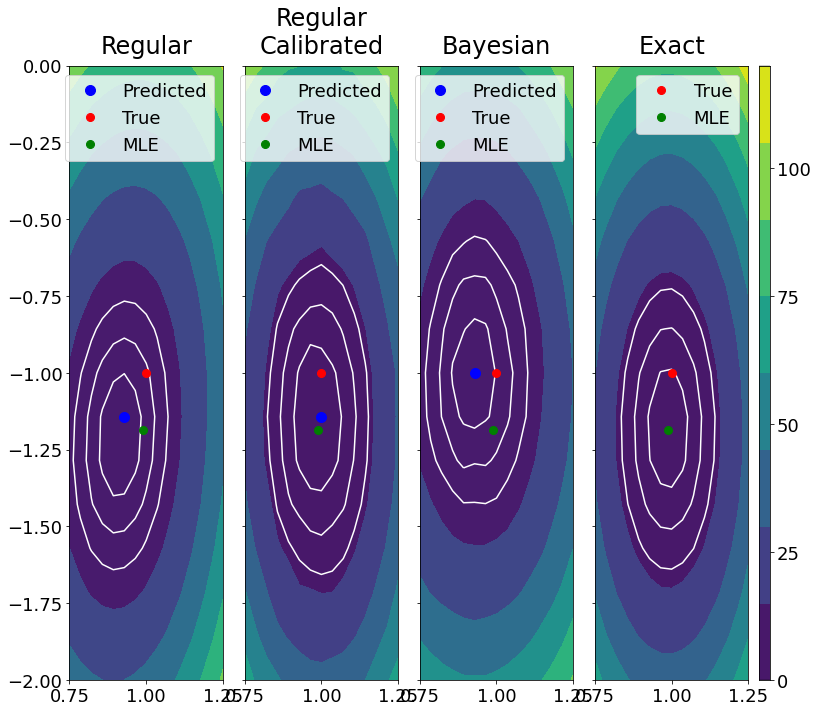

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(len(contours)*10, 10))

grid = ImageGrid(
    fig,
    111,
    # nrows_ncols=(2, np.ceil(len(contours)/2).astype(int)),
    nrows_ncols=(1, len(contours)),
    axes_pad=0.3,
    share_all=True,
    cbar_location="right",
    cbar_mode="single",
    cbar_size="7%",
    cbar_pad=0.15,
)

for ax, contour_name in zip(grid, contours):
    contour = 2*contours[contour_name]

    if contour_name != 'Exact':
        contour = contour - contour.min()
        alpha_min, beta_min = mles[contour_name]
        ax.plot([alpha_min], [beta_min], 'bo', markersize=10, label='Predicted')
    
    im = ax.contourf(*plot_grid.meshgrid(), contour)
    ax.contour(
        *plot_grid.meshgrid(),
        contour,
        colors=['w'],
        levels=[chi2.ppf(0.683, df=2),
                chi2.ppf(0.9545, df=2),
                chi2.ppf(0.9973, df=2)]
    )
    ax.plot([true_alpha], [true_beta], "ro", markersize=8, label='True')
    ax.plot([alpha_mle], [beta_mle], "go", markersize=8, label='MLE')
    ax.legend()
    ax.set_title(contour_name.replace(' ', '\n'))

ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.tight_layout()
plt.show()

{'Brier Score': {'Model': 0.1258034669446903}, 'F1 Score': {'Model': 0.8008255933952528}, 'Expected Calibration Error': {'Model': 0.023356251}}


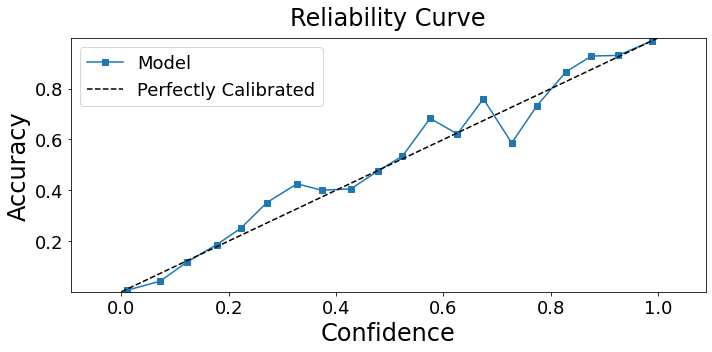

In [12]:
from active_learning_ratio_estimation.model.validation import plot_calibration
calibration_curves, scores = plot_calibration(bayesian_model, dataset=ds, n_data=int(1e3), n_bins=20)
print(scores)
plt.show()